##Importing necessary libraries and data

In [ ]:
import pandas as pd
import numpy as np
import nltk
nltk.download('all')
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!pip install nlpaug

In [ ]:
!pip install tensorflow 

In [4]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as naf

from nlpaug.util import Action

In [5]:
from wordcloud import WordCloud
from tqdm.notebook import tqdm, trange
import re
import string
import matplotlib

In [7]:
med_data = pd.read_csv('Train.csv')
med_data.head()

,Id,description,medical_specialty,sample_name,transcription
0,1,Patient had a recurrent left arm pain after h...,Cardiovascular / Pulmonary,Angina - Consult,"HISTORY OF PRESENT ILLNESS: , The patient is a..."
1,2,The patient is an 84-year-old female presente...,Cardiovascular / Pulmonary,Pericardial Effusion,"REASON FOR CONSULTATION:, Pericardial effusio..."
2,3,Hand dermatitis.,Dermatology,Dermatitis - SOAP,"SUBJECTIVE:, This is a 29-year-old Vietnamese..."
3,4,Recurrent degenerative spondylolisthesis and ...,Surgery,Lumbar Re-exploration,"PREOPERATIVE DIAGNOSIS: , Recurrent degenerati..."
4,5,Chiropractic IME with old files review. Deta...,IME-QME-Work Comp etc.,Chiropractic IME - 2,"DATE OF INJURY : October 4, 2000,DATE OF EXAMI..."


##Data Exploration

In [8]:
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

In [9]:
text = set()
for transcript in tqdm(med_data.transcription):
  for word in re.split('[;,.%/() ]', str(transcript)):
    if len(word)>2 and word not in STOPWORDS:
      text.add(word)

  0%|          | 0/3384 [00:00<?, ?it/s]

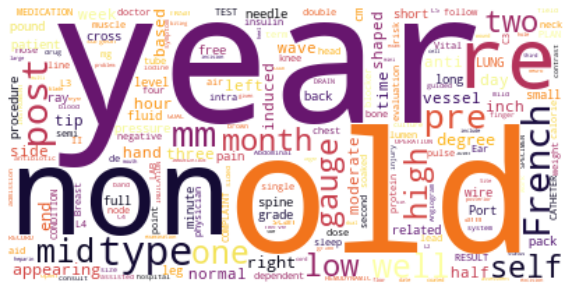

In [10]:
#Plotting the word map for the transcriptions in the dataset

word_cloud = WordCloud(collocations = False, background_color = 'white', colormap=matplotlib.cm.inferno).generate(" ".join(text))
plt.figure(figsize=(10, 6))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Text(0.5, 0, 'samples')

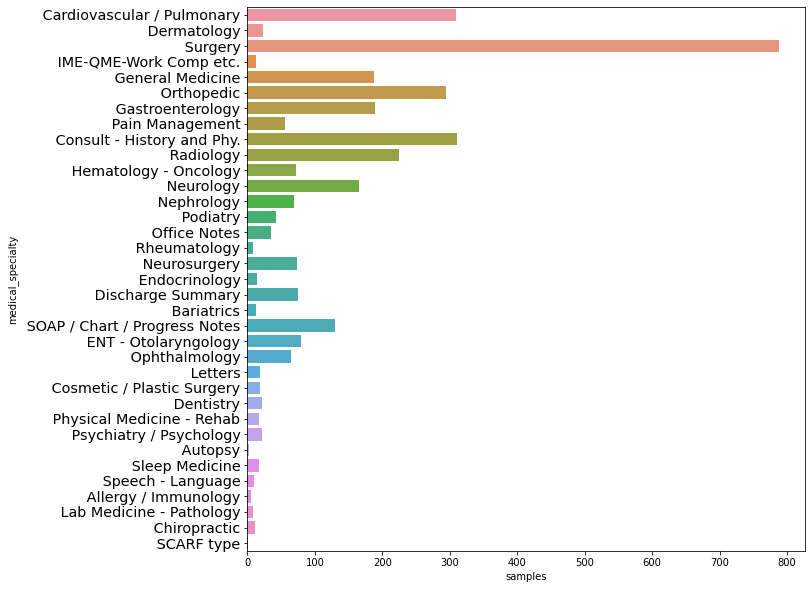

In [12]:
#Plotting the distribution of data across the different specialties
plt.figure(figsize=(10, 10))
sns.countplot(y=med_data.medical_specialty)

plt.yticks(
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.gca().set_xlabel('samples')

In [13]:
med_data.isnull().mean()*100

Id                   0.00000
description          0.00000
medical_specialty    0.00000
sample_name          0.00000
transcription        0.70922
dtype: float64

##Data Preprocessing

####Retaining observations with Non-Null transcriptions

In [14]:
med_data = med_data.loc[:, med_data.isnull().mean() < .99]
med_data = med_data.drop(med_data.index[12])

In [15]:
med_data = med_data[med_data['transcription'].notna()]

In [16]:
med_data.isnull().mean()*100

Id                   0.0
description          0.0
medical_specialty    0.0
sample_name          0.0
transcription        0.0
dtype: float64

####Retaining specialties having atleast 20 observations

In [17]:
med_data['medical_specialty'].unique()

array([' Cardiovascular / Pulmonary', ' Dermatology', ' Surgery',
       ' IME-QME-Work Comp etc.', ' General Medicine', ' Orthopedic',
       ' Gastroenterology', ' Pain Management',
       ' Consult - History and Phy.', ' Radiology',
       ' Hematology - Oncology', ' Neurology', ' Nephrology', ' Podiatry',
       ' Office Notes', ' Rheumatology', ' Neurosurgery',
       ' Endocrinology', ' Discharge Summary', ' Bariatrics',
       ' SOAP / Chart / Progress Notes', ' ENT - Otolaryngology',
       ' Ophthalmology', ' Letters', ' Cosmetic / Plastic Surgery',
       ' Dentistry', ' Physical Medicine - Rehab',
       ' Psychiatry / Psychology', ' Autopsy', ' Sleep Medicine',
       ' Speech - Language', ' Allergy / Immunology',
       ' Lab Medicine - Pathology', ' Chiropractic', ' SCARF type'],
      dtype=object)

In [18]:
specialisations_data = med_data.groupby("medical_specialty").agg("count")["transcription"].reset_index()
specialisations_data

,medical_specialty,transcription
0,Allergy / Immunology,5
1,Autopsy,2
2,Bariatrics,12
3,Cardiovascular / Pulmonary,308
4,Chiropractic,11
5,Consult - History and Phy.,309
6,Cosmetic / Plastic Surgery,19
7,Dentistry,21
8,Dermatology,23
9,Discharge Summary,75


In [19]:
specs_tokeep = specialisations_data.loc[specialisations_data["transcription"]>20]
med_data = med_data[med_data["medical_specialty"].isin(specs_tokeep["medical_specialty"])]

In [20]:
spec_count = med_data.groupby("medical_specialty").agg("count")["transcription"].reset_index()
spec_count

,medical_specialty,transcription
0,Cardiovascular / Pulmonary,308
1,Consult - History and Phy.,309
2,Dentistry,21
3,Dermatology,23
4,Discharge Summary,75
5,ENT - Otolaryngology,77
6,Gastroenterology,183
7,General Medicine,188
8,Hematology - Oncology,72
9,Nephrology,69


In [21]:
med_data = med_data[['transcription', 'medical_specialty']]

####Visualising the distribution of observations w.r.t medical_specialties once again 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'samples')

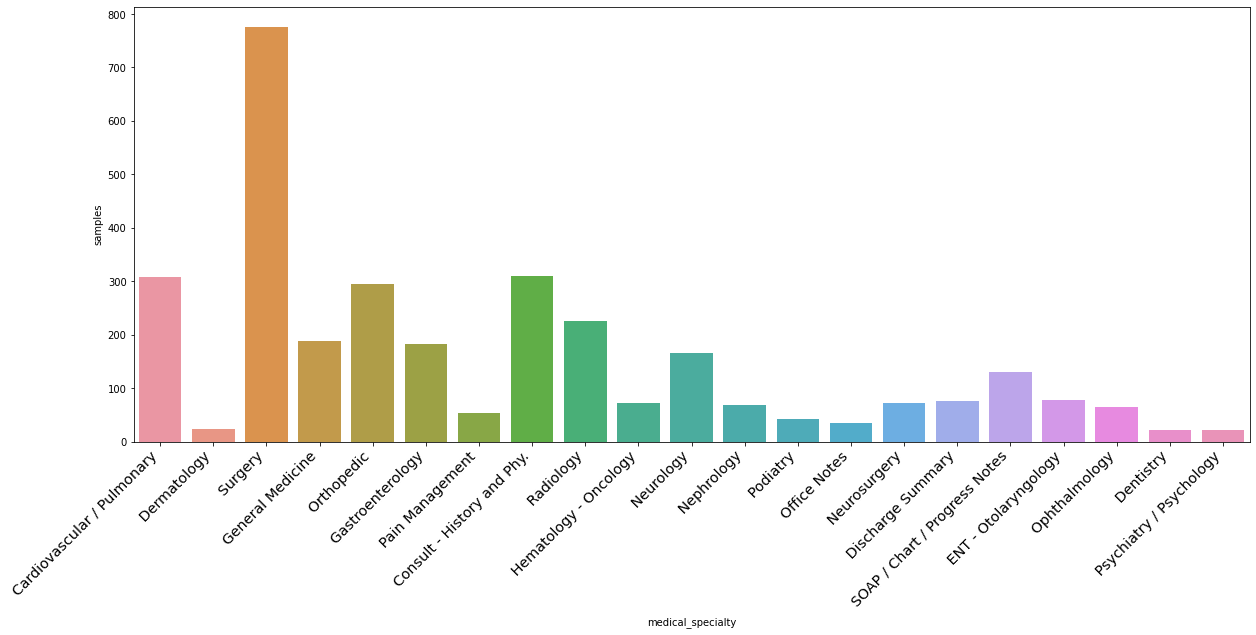

In [22]:
plt.figure(figsize=(20,8))
x = med_data.medical_specialty.value_counts()
sns.countplot(med_data["medical_specialty"])
#plt.tight_layout()
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.gca().set_ylabel('samples')

##Data Augmentation

#####The distribution of data into the different specialties is imbalanced. In order to have categories with similiar number of records, we use data augmentation. Here, we use Synonyms for augmentation from the wordnet database. 

In [23]:
aug = naw.SynonymAug(aug_src='wordnet', name='Synonym_Aug', aug_max=24)

In [24]:
for i in trange(0, len(spec_count)-1):
    aug_multiplier = int(round(spec_count.transcription.max() / spec_count.transcription[i],0)) - 1
    data_filter = med_data.loc[med_data['medical_specialty'] == spec_count.medical_specialty[i]]
    for j in tqdm(data_filter.index):
        temps=aug.augment(data_filter.transcription[j],n=aug_multiplier)
        for sent in temps:
            medical_data1 = {'transcription': sent, 'medical_specialty': spec_count.medical_specialty[i]}
            med_data = med_data.append(medical_data1, ignore_index = True)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/308 [00:00<?, ?it/s]

  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/166 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/294 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

#####Distribution of data into the different medical_specialties after augmentation

In [25]:
med_data.groupby("medical_specialty").agg("count")["transcription"].reset_index()

,medical_specialty,transcription
0,Cardiovascular / Pulmonary,924
1,Consult - History and Phy.,927
2,Dentistry,777
3,Dermatology,782
4,Discharge Summary,750
5,ENT - Otolaryngology,770
6,Gastroenterology,732
7,General Medicine,752
8,Hematology - Oncology,792
9,Nephrology,759


##Text Preprocessing

In [26]:
def text_preprocessing(data):
  data = str(data).lower()
  data = re.sub('\[.*?\]', '', data)
  data = re.sub('https?://\S+|www\.\S+', '', data)
  data = re.sub('<.*?>+', '', data)
  data = re.sub('[%s]' % re.escape(string.punctuation), '', data)
  data = re.sub('\n', '', data)
  data = re.sub('\w*\d\w*', '', data)
  return data

In [27]:
def remove_stopwords(text):
  return " ".join([word for word in text.split() if word not in STOPWORDS])

In [28]:
med_data["transcription"] = med_data["transcription"].map(lambda text: text_preprocessing(text))

In [29]:
med_data["transcription"] = med_data["transcription"].map(lambda text: remove_stopwords(text))

In [30]:
med_data["word_cnt"] = med_data["transcription"].map(lambda text: len(str(text).split()))

In [31]:
Y = pd.get_dummies(med_data["medical_specialty"]).values
print("Shape of label Tensor: ", Y.shape)

Shape of label Tensor:  (16560, 21)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Frequency')

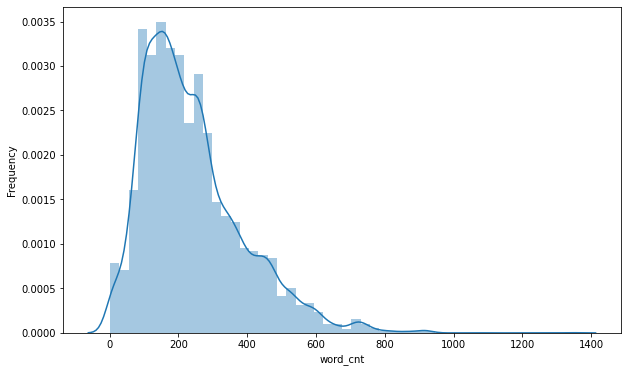

In [208]:
plt.figure(figsize=(10,6))
sns.distplot(med_data["word_cnt"])
plt.ylabel("Frequency")

In [33]:
documents = []
for transcript in med_data["transcription"]:
  documents.append(transcript.split(' '))

In [34]:
len(documents)

16560

##Building word2vec model

In [35]:
from gensim.models import Word2Vec

In [172]:
# Training the Word2Vec model
model = Word2Vec(documents, #Word list
                   min_count=5, #Ignore all words with total frequency lower than this                           
                   workers=4, #Number of CPUs
                   size=100,  #Embedding size
                   window=5, #Maximum Distance between current and predicted word
                   seed=2
                  # iter=10   #Number of iterations over the text corpus
                  )

In [173]:
#How many words in the model and how many features
model.wv.vectors.shape

(19390, 100)

In [174]:
all_words = model.wv.index2word              #key_to_index
top_words = model.wv.index2word[0:5]   
top_words

['patient', 'right', 'left', 'history', 'procedure']

In [175]:
print('Vocabulary size: %d' % len(all_words))

Vocabulary size: 19390


In [176]:
# Finding Word Vectors
vector = model.wv['mmode']
vector

array([-0.01918128,  0.1429126 ,  0.04058888, -0.05096433,  0.08461446,
        0.04371824,  0.02795762, -0.04079987, -0.01291113, -0.05376827,
        0.06531687, -0.00104099,  0.05162185,  0.04739582, -0.00306763,
       -0.11981384, -0.09163498,  0.00771921, -0.01747221,  0.02243393,
       -0.0135585 , -0.09069251,  0.08441661, -0.04776355,  0.07631955,
        0.00561636, -0.02156663, -0.01915887,  0.02935542,  0.01355745,
       -0.07326031, -0.07643625,  0.02420407,  0.02901172, -0.08232328,
       -0.00587831, -0.08954427,  0.01945523, -0.10292254, -0.00382246,
       -0.11434747, -0.04808906, -0.06721511,  0.03586689, -0.00658377,
        0.01455375, -0.05670521, -0.07881317,  0.08457015, -0.0347148 ,
        0.02205422, -0.02383353,  0.07138535,  0.06071797, -0.07728902,
       -0.00462762, -0.0124808 ,  0.03121153,  0.01400523, -0.03400251,
       -0.02375378, -0.13045426,  0.1291367 ,  0.10710935,  0.11139596,
        0.05313245,  0.05339649,  0.08529819,  0.06029308, -0.05

In [177]:
#Finding similar words
similar = model.wv.most_similar('anesthetic')
similar

[('anaesthetic', 0.8488205671310425),
 ('anaesthesia', 0.8236177563667297),
 ('anesthesia', 0.7690296173095703),
 ('percolation', 0.6298069953918457),
 ('anesthesiaprocedure', 0.6063373684883118),
 ('footanesthesia', 0.6058767437934875),
 ('interscalene', 0.6044514775276184),
 ('endotrachealestimated', 0.593217134475708),
 ('shoplift', 0.5772348046302795),
 ('sedationcomplications', 0.5742250680923462)]

##Saving the model

In [178]:
model.save("word2vec_Medical Specialty Classification")

##Train test validation split

In [179]:
from sklearn.model_selection import train_test_split

In [180]:
X = med_data["transcription"]
y = Y

In [181]:
#train test validation split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify = y)
    
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1, stratify = y_train)

In [182]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(9936,)
(3312,)
(9936, 21)
(3312, 21)
(3312,)
(3312, 21)


In [183]:
# building tokenizer to form a token for each word in each transcription

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding

In [184]:
#Convert words to integers

top_words = 10000 #reducing no of words to increase the processing speed

tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(X_train)

In [185]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [186]:
# pad sequences to mmake each transcription of the same size
#taking 300  based on avg length of the transcription form histogram
padding_max_len = 300

X_train = pad_sequences(X_train, maxlen=padding_max_len, padding='post')
X_test = pad_sequences(X_test, maxlen=padding_max_len, padding='post')

##Building Embedding Matrix

In [187]:
# Building embedding matrix from above Word2Vec model(pre trained model) 

word2vec_model = Word2Vec.load("word2vec_Medical Specialty Classification")  #loading the one created above

In [188]:
word2vec_model.wv.vectors.shape

(19390, 100)

In [189]:
#embedding length
embedding_vector_length = word2vec_model.wv.vectors.shape[1]  
embedding_vector_length

100

In [190]:
#Initialising an embedding matrix with zeros

embedding_matrix = np.zeros((top_words+1, embedding_vector_length))

tokenizer.word_index.items()

for word,key in sorted(tokenizer.word_index.items(), key = lambda x:x[1]):
  if key > top_words:
    break
  if word in word2vec_model.wv.index2word:
    #print(word)
    embedding_vector = word2vec_model.wv[word]
    #print(embedding_vector)
    embedding_matrix[key] = embedding_vector
    #print(embedding_matrix[i])

In [191]:
embedding_matrix[tokenizer.word_index['procedure']]

array([ 2.50091243, -0.48142892,  2.37951875, -0.36878556, -1.65133357,
        1.13016117,  1.01246381,  0.20689268,  4.17229319, -0.09238897,
       -3.06413341, -1.89978588,  0.06511934, -2.37923813,  4.07610226,
       -0.79719114,  0.44704863, -1.61001778, -1.02063715,  1.54322195,
       -0.82275087, -0.38025296, -1.69158268,  2.41213465, -0.96904105,
       -1.56283391, -0.2545478 , -1.47889984,  1.95428801, -4.84367085,
       -0.47389212, -0.508174  ,  0.80516696, -1.11151552, -3.2838614 ,
       -0.34280255, -2.12366748,  0.30685487, -0.30370876,  0.10568991,
       -0.87772256, -1.99101686,  1.32416654,  1.7283535 ,  0.02437231,
       -1.72113407, -0.18265161,  2.07457757,  0.34795958,  1.07721174,
        0.31864044, -1.4788177 ,  1.4695065 , -2.00027275,  2.52495694,
        2.5465486 ,  1.46326721,  2.75761342, -1.64580512,  2.11529613,
        1.14774787, -0.68898284,  1.02022278,  0.13019003,  0.10126094,
       -0.16830629, -2.75858212,  0.87363321, -1.45001876, -0.96

##Creating an Embedding Layer

In [192]:
# Create an embedding layer
#Output from Embedding is 3 dimension
#batch_size x max_review_length x embedding_vector_length

embedding_layer = Embedding(top_words+1, embedding_vector_length, weights=[embedding_matrix],
                             input_length=padding_max_len,trainable=False)


##Model 0

In [154]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [94]:
import xgboost as xgb 

In [83]:
x_train_embed = (embedding_layer(X_train).numpy())
x_test_embed = (embedding_layer(X_test).numpy())

In [127]:
rf = RandomForestClassifier(random_state=12)

In [149]:
grid_params = {'n_estimators':[100, 150, 200], 'max_depth':[20, 30, 40, 50], 'min_samples_split':[1, 5, 9], 'ccp_alpha':[0, 4, 10, 20]}

In [155]:
random_search = RandomizedSearchCV(rf, grid_params, scoring="accuracy", random_state=2, return_train_score=True, n_jobs=-1)

In [152]:
# grid_search = GridSearchCV(rf, param_grid=grid_params, n_jobs=-1, return_train_score=True, scoring='accuracy', verbose=4)

In [ ]:
clf = random_search.fit(X_train, y_train)

In [159]:
random_search.best_estimator_

RandomForestClassifier(ccp_alpha=0, max_depth=20, min_samples_split=5,
                       n_estimators=200, random_state=12)

In [168]:
y_predtrain = clf.predict(X_train)
accuracy_score(y_train, y_predtrain)

0.4277375201288245

In [170]:
y_preds = clf.predict(X_test)
accuracy_score(y_preds, y_test)

0.06370772946859904

##Imports for building LSTM models

In [193]:
# Using LSTM

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,BatchNormalization,Embedding,LSTM ,Bidirectional
from tensorflow.keras import regularizers

##Model 1

In [194]:
model1 = Sequential()

model1.add(embedding_layer)

#LSTM
model1.add(LSTM(32))

#dense layer
model1.add(Dense(units=21,activation='softmax')) 

model1.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
print(model1.summary())


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 100)          1000100   
                                                                 
 lstm_3 (LSTM)               (None, 32)                17024     
                                                                 
 dense_3 (Dense)             (None, 21)                693       
                                                                 
Total params: 1,017,817
Trainable params: 17,717
Non-trainable params: 1,000,100
_________________________________________________________________
None


In [195]:
model_history = model1.fit(X_train, y_train, batch_size=200, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
50/50 [==============================] - 23s 416ms/step - loss: 2.9907 - accuracy: 0.0943 - val_loss: 2.9211 - val_accuracy: 0.1310
Epoch 2/30
50/50 [==============================] - 16s 319ms/step - loss: 2.8347 - accuracy: 0.1533 - val_loss: 2.7373 - val_accuracy: 0.1724
Epoch 3/30
50/50 [==============================] - 16s 318ms/step - loss: 2.6573 - accuracy: 0.1888 - val_loss: 2.6120 - val_accuracy: 0.2002
Epoch 4/30
50/50 [==============================] - 16s 317ms/step - loss: 2.5729 - accuracy: 0.2145 - val_loss: 2.5562 - val_accuracy: 0.2147
Epoch 5/30
50/50 [==============================] - 16s 317ms/step - loss: 2.4941 - accuracy: 0.2403 - val_loss: 2.4897 - val_accuracy: 0.2403
Epoch 6/30
50/50 [==============================] - 16s 317ms/step - loss: 2.4551 - accuracy: 0.2542 - val_loss: 2.4867 - val_accuracy: 0.2421
Epoch 7/30
50/50 [==============================] - 16s 315ms/step - loss: 2.4430 - accuracy: 0.2544 - val_loss: 2.4604 - val_accuracy: 0.2579

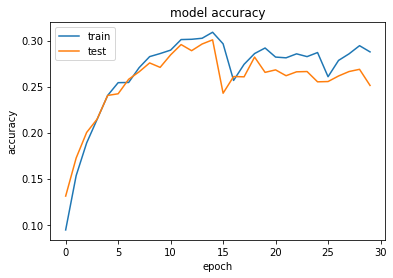

In [196]:
# summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

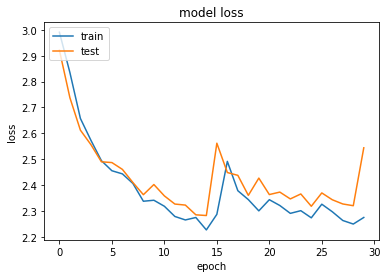

In [197]:
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##Model 2

####In order to improve upon the previous model we make use of a bidirectional LSTM model to capture more context. We also increase the number of neurons.

In [198]:
model2 = Sequential()

model2.add(embedding_layer)

model2.add(Bidirectional(LSTM(64)))

model2.add(Dense(units=21,activation='softmax')) 

model2.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
print(model2.summary())


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 100)          1000100   
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              84480     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 21)                2709      
                                                                 
Total params: 1,087,289
Trainable params: 87,189
Non-trainable params: 1,000,100
_________________________________________________________________
None


In [199]:
model_history = model2.fit(X_train, y_train, batch_size=100, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
100/100 [==============================] - 68s 633ms/step - loss: 2.3579 - accuracy: 0.3453 - val_loss: 1.7142 - val_accuracy: 0.5226
Epoch 2/10
100/100 [==============================] - 62s 618ms/step - loss: 1.3766 - accuracy: 0.6024 - val_loss: 1.1973 - val_accuracy: 0.6486
Epoch 3/10
100/100 [==============================] - 62s 622ms/step - loss: 1.0265 - accuracy: 0.6837 - val_loss: 1.0708 - val_accuracy: 0.6564
Epoch 4/10
100/100 [==============================] - 62s 621ms/step - loss: 0.8667 - accuracy: 0.7223 - val_loss: 0.9458 - val_accuracy: 0.6899
Epoch 5/10
100/100 [==============================] - 62s 615ms/step - loss: 0.7574 - accuracy: 0.7471 - val_loss: 0.8902 - val_accuracy: 0.7023
Epoch 6/10
100/100 [==============================] - 62s 619ms/step - loss: 0.6857 - accuracy: 0.7591 - val_loss: 0.8733 - val_accuracy: 0.6984
Epoch 7/10
100/100 [==============================] - 62s 622ms/step - loss: 0.6382 - accuracy: 0.7721 - val_loss: 0.8624 - val_ac

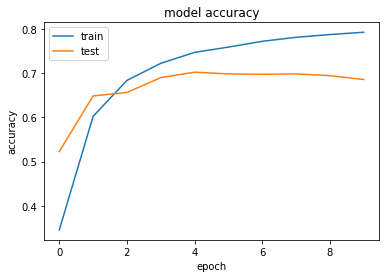

In [200]:
# summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

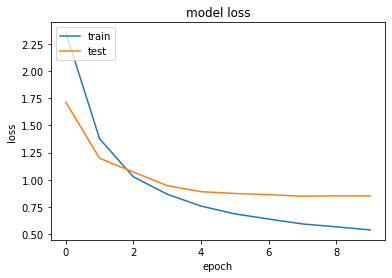

In [201]:
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##Model 3

####Clearly model 2 was a significant improvement from model 1, however analysing the plots of loss/epoch we can see that the model begins to overfit. We train another Bi-LSTM model with lesser number of neurons to address this problem

In [202]:
#improving above overfitted model:

model2_1 = Sequential()

model2_1.add(embedding_layer)

model2_1.add(Bidirectional(LSTM(32)))

model2_1.add(Dense(units=21,activation='softmax')) 

model2_1.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
print(model2_1.summary())


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 100)          1000100   
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               34048     
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 21)                1365      
                                                                 
Total params: 1,035,513
Trainable params: 35,413
Non-trainable params: 1,000,100
_________________________________________________________________
None


In [203]:
model_history = model2_1.fit(X_train, y_train, batch_size=100, epochs=8, validation_data=(X_test, y_test))

Epoch 1/8
100/100 [==============================] - 42s 376ms/step - loss: 2.6196 - accuracy: 0.2586 - val_loss: 2.2187 - val_accuracy: 0.4106
Epoch 2/8
100/100 [==============================] - 37s 366ms/step - loss: 1.8875 - accuracy: 0.4960 - val_loss: 1.6532 - val_accuracy: 0.5489
Epoch 3/8
100/100 [==============================] - 37s 369ms/step - loss: 1.4429 - accuracy: 0.6081 - val_loss: 1.3707 - val_accuracy: 0.6199
Epoch 4/8
100/100 [==============================] - 37s 372ms/step - loss: 1.1905 - accuracy: 0.6625 - val_loss: 1.2153 - val_accuracy: 0.6428
Epoch 5/8
100/100 [==============================] - 38s 384ms/step - loss: 1.0367 - accuracy: 0.6929 - val_loss: 1.1127 - val_accuracy: 0.6588
Epoch 6/8
100/100 [==============================] - 41s 404ms/step - loss: 0.9352 - accuracy: 0.7146 - val_loss: 1.0409 - val_accuracy: 0.6800
Epoch 7/8
100/100 [==============================] - 37s 369ms/step - loss: 0.8789 - accuracy: 0.7246 - val_loss: 1.0289 - val_accuracy:

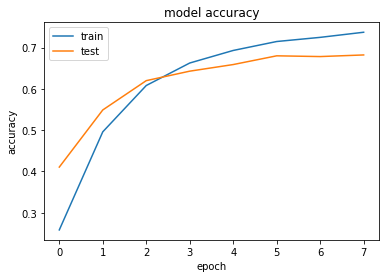

In [204]:
# summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

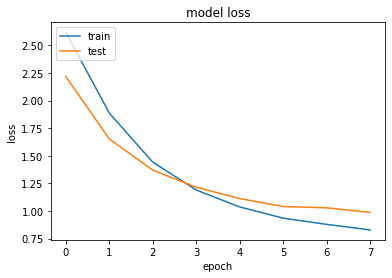

In [205]:
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()